# Xây dựng mô hình và dự đoán

## Mục tiêu
Như đã nhận xét ở phần phân tích dữ liệu, chúng ta sẽ xây dựng mô hình để dự đoán cho năm `2023`. Vậy chúng ta có thể viết mục tiêu như sau:
- Input: Dữ liệu các năm trước năm 2023
- Output: Dự đoán xu hướng Covid-19 trong năm 2023

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import datetime as dt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  HuberRegressor)
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20, 8)
plt.style.use('fivethirtyeight')

## Feature Engineering and Feature Selection

### Feature Selection

In [2]:
DATA_PATH = Path('data/')

In [3]:
cols = ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases']
vn_data = pd.read_csv(DATA_PATH / 'vietnam-covid-data.csv', usecols=cols)

In [4]:
def convert_toDt(df, cols):
    df[cols] = df[cols].apply(
        lambda x: dt.datetime.strptime(x, '%m/%d/%Y')
    )
    return df

In [5]:
vn_data = convert_toDt(vn_data, 'date')

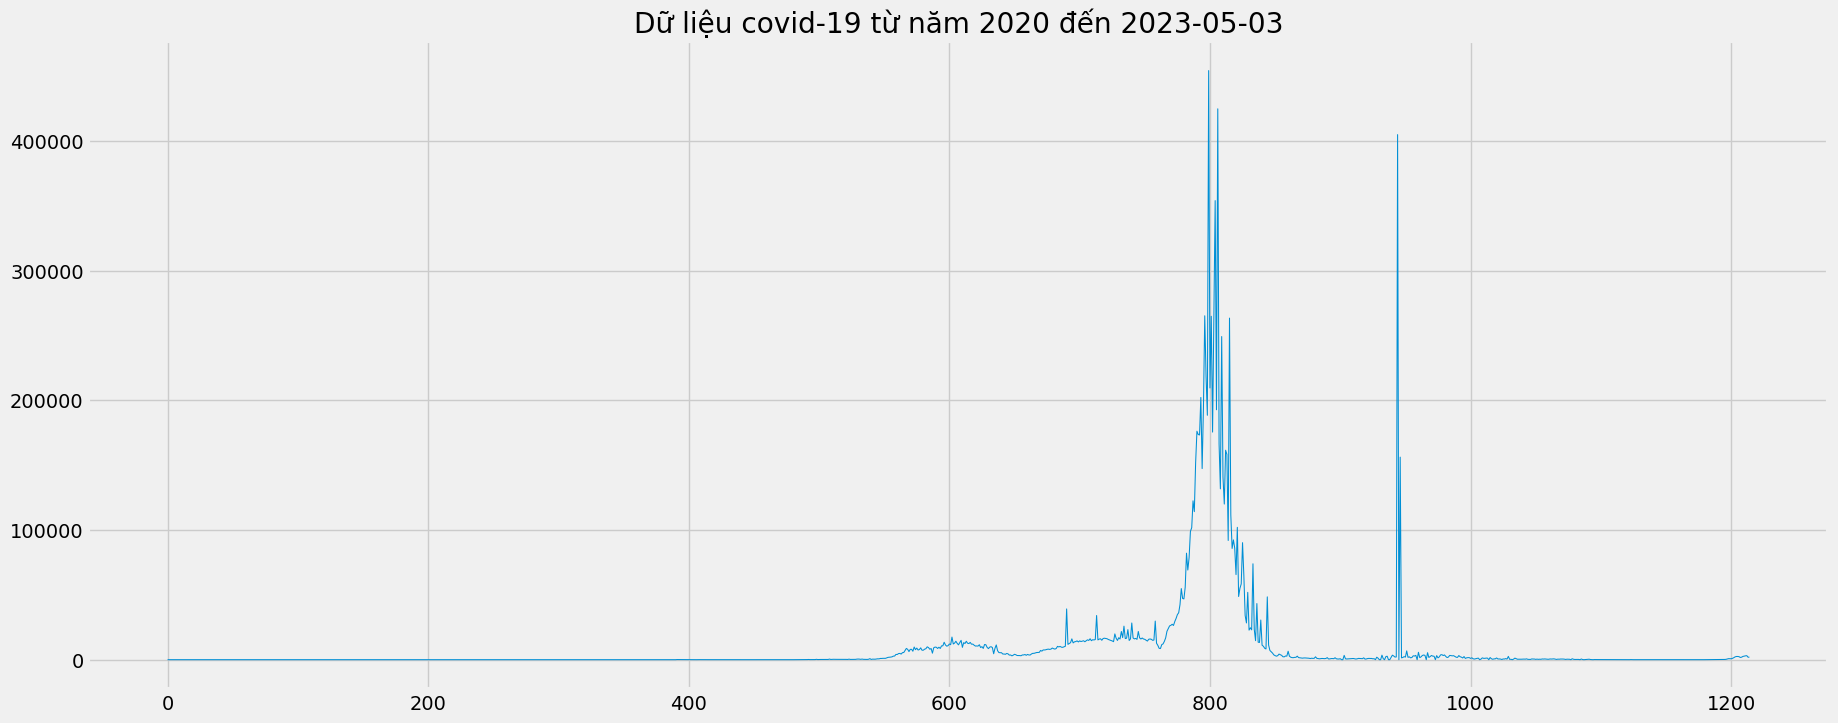

In [6]:
vn_data['new_cases'].plot(linewidth=0.75)
plt.title('Dữ liệu covid-19 từ năm 2020 đến 2023-05-03')
plt.show()

> Từ biểu đồ chúng ta thấy rằng, có những khoảng thời gian như giai đoạn đầu số ca covid mới mắc rất ít, tuy nhiên càng về sau số ca covid-19 ghi nhận theo ngày tăng lên đột biến ví dụ như khoảng tháng 8 năm 2022, do đó việc dự đoán theo ngày gần như là không thể. Do con người là yếu tố chính dẫn đến việc số ca covid tăng nhiều hay tăng ít

#### Kiểm tra tính phân phối của dữ liệu

In [7]:
def getDataByYear(df, year=2020):
    start_date = str(year)
    end_date = str(year) + '-12-31'
    data = df[df['date'].between(start_date, end_date)]
    
    return data

In [8]:
def plot_kde_box(df, year=None, bw_adjust=1, cols='new_cases', title=None):
    fig, axs = plt.subplots(1, 2)
    
    sns.kdeplot(
        data=df,
        x=cols,
        bw_adjust=bw_adjust,
        ax=axs[0]
    )
    sns.boxplot(
        data=df,
        x=cols,
        ax=axs[1]
    )
    axs[0].set_title('KDE')
    axs[1].set_title('Box plot')
    if title:
        plt.suptitle(title, fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()
    

In [9]:
vn_data_2020 = getDataByYear(vn_data)
vn_data_2021 = getDataByYear(vn_data, year=2021)
vn_data_2022  = getDataByYear(vn_data, year=2022)

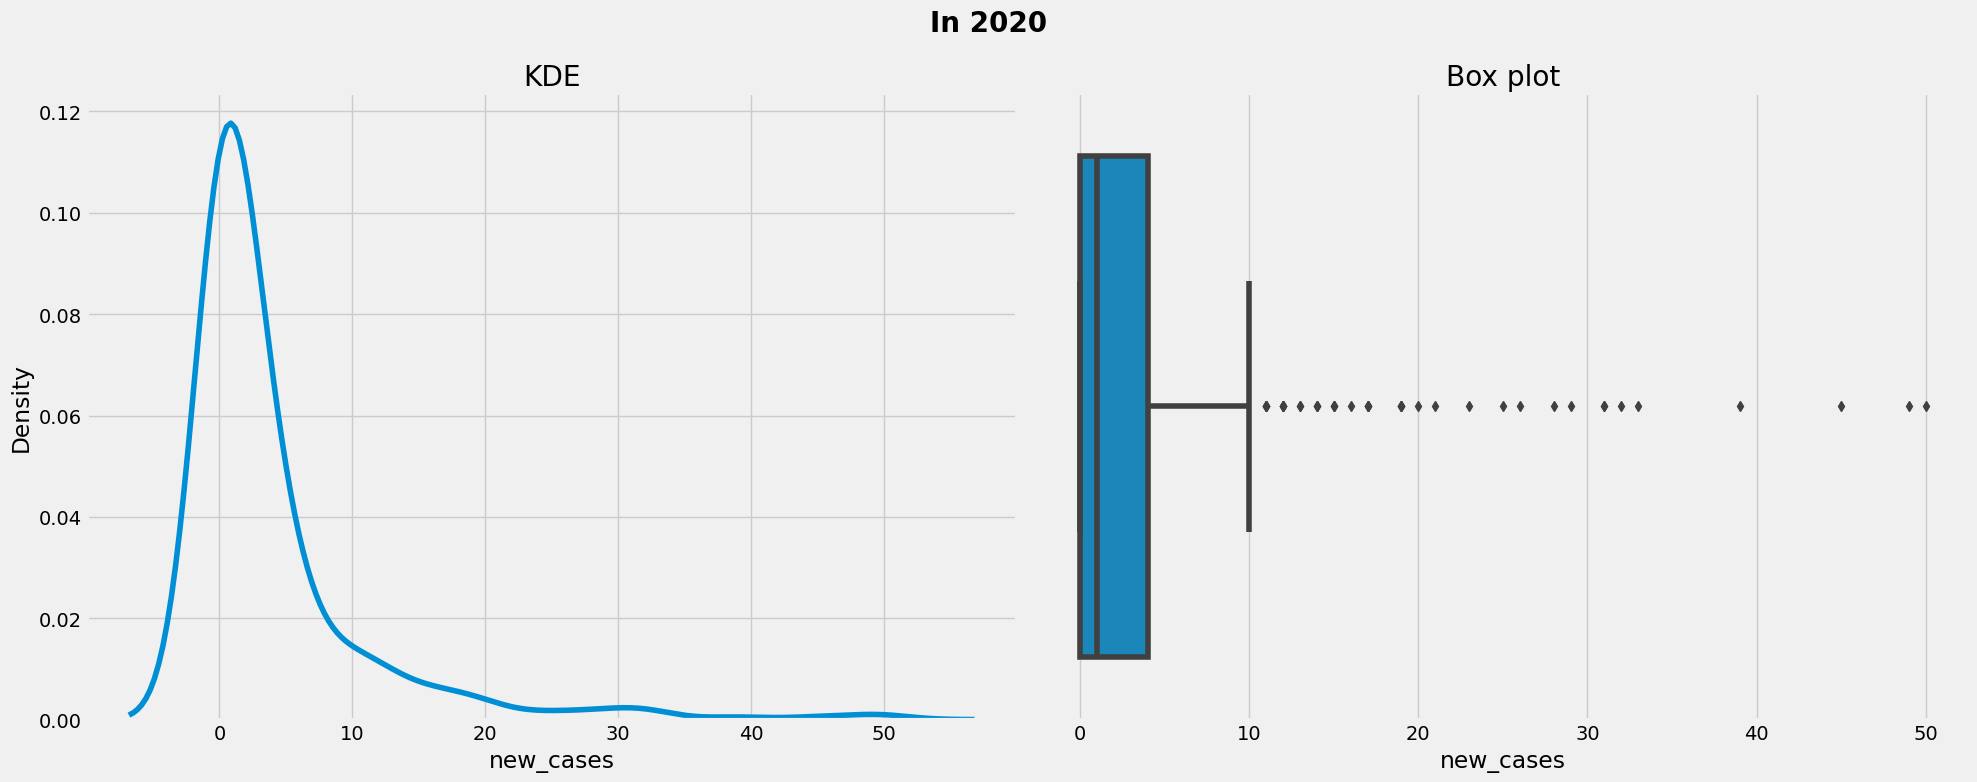

In [10]:
plot_kde_box(vn_data_2020, year=2020, title='In 2020')

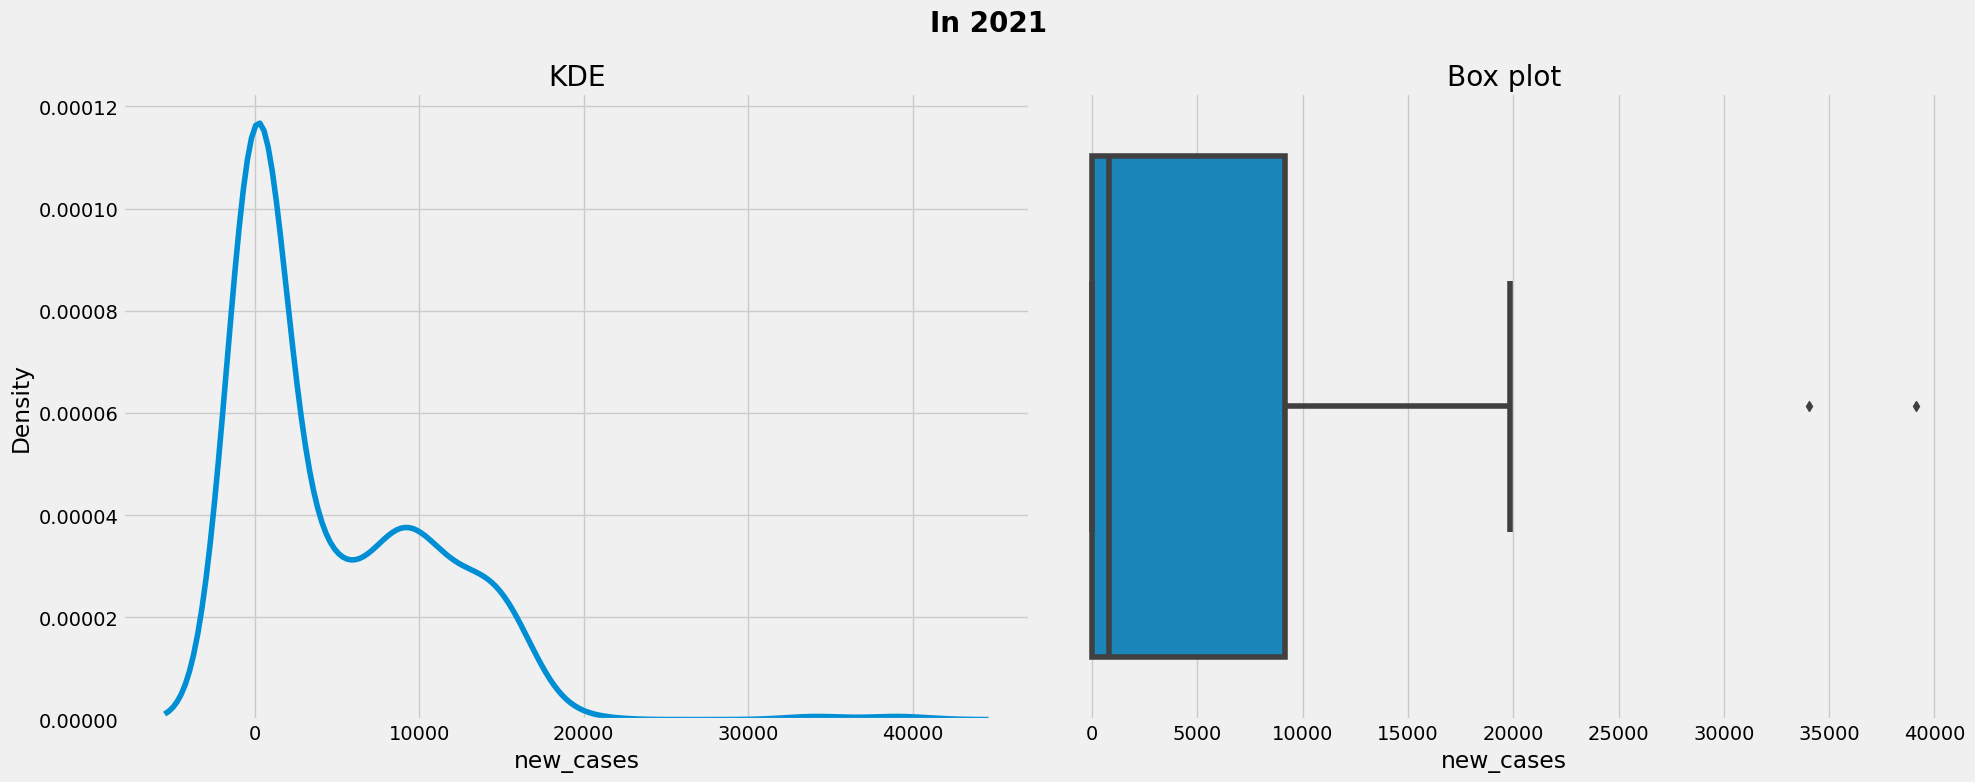

In [11]:
plot_kde_box(vn_data_2021, year=2021, title='In 2021')


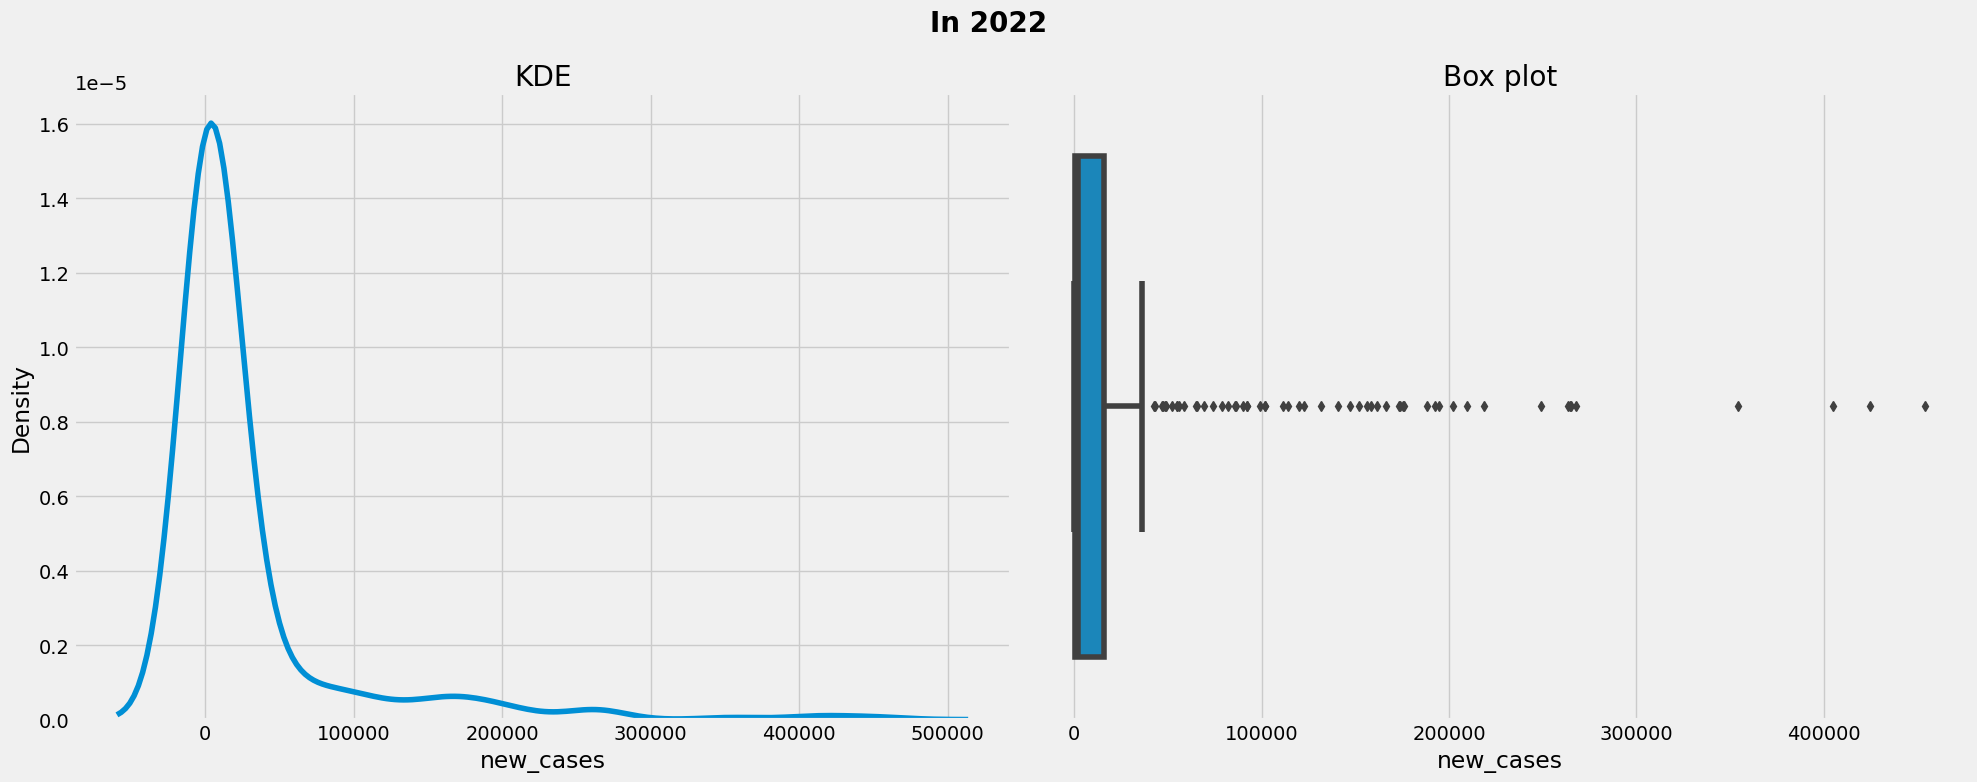

In [12]:
plot_kde_box(vn_data_2022, year=2022, title='In 2022')


- Từ các trực quan trên chúng ta có thể thấy rằng, dữ liệu của chúng ta có rất nhiều các điểm **ngoại lai**, tuy nhiên đây là số liệu thực tế, là diễn biến phức tạp của dịch covid-19 nên chúng ta cũng không thể nào bỏ đi các điểm này
- Như chúng ta đã biết các điểm ngoại lai thường là không tốt khi xây dựng mô hình vì nó ảnh hưởng đến độ nhạy của mô hình

### Feature Engineering

In [13]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [39]:
def plot_forecast(model, start, train, test, order, ax):
    forecast = pd.DataFrame(model.forecast(test.shape[0]))
    train.loc[start:].plot(style='--', ax=ax)
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    p, d, q = order
    rmse = np.sqrt(mean_squared_error(test, forecast))
    ax.set_title(f'p={p}, d={d}, q={q}, RMSE={round(rmse, 2)}', fontsize=16)
    return forecast

#### Split Data

In [15]:
vn_data.set_index('date', inplace=True)

In [16]:
train, test = vn_data.loc[vn_data.index < '2023-01-01', 'new_cases'], vn_data.loc[vn_data.index >= '2023-01-01', 'new_cases']

In [17]:
train_7D = train.resample('7D').mean()

In [18]:
df = pd.DataFrame(train_7D)
df.columns = ['new_cases']

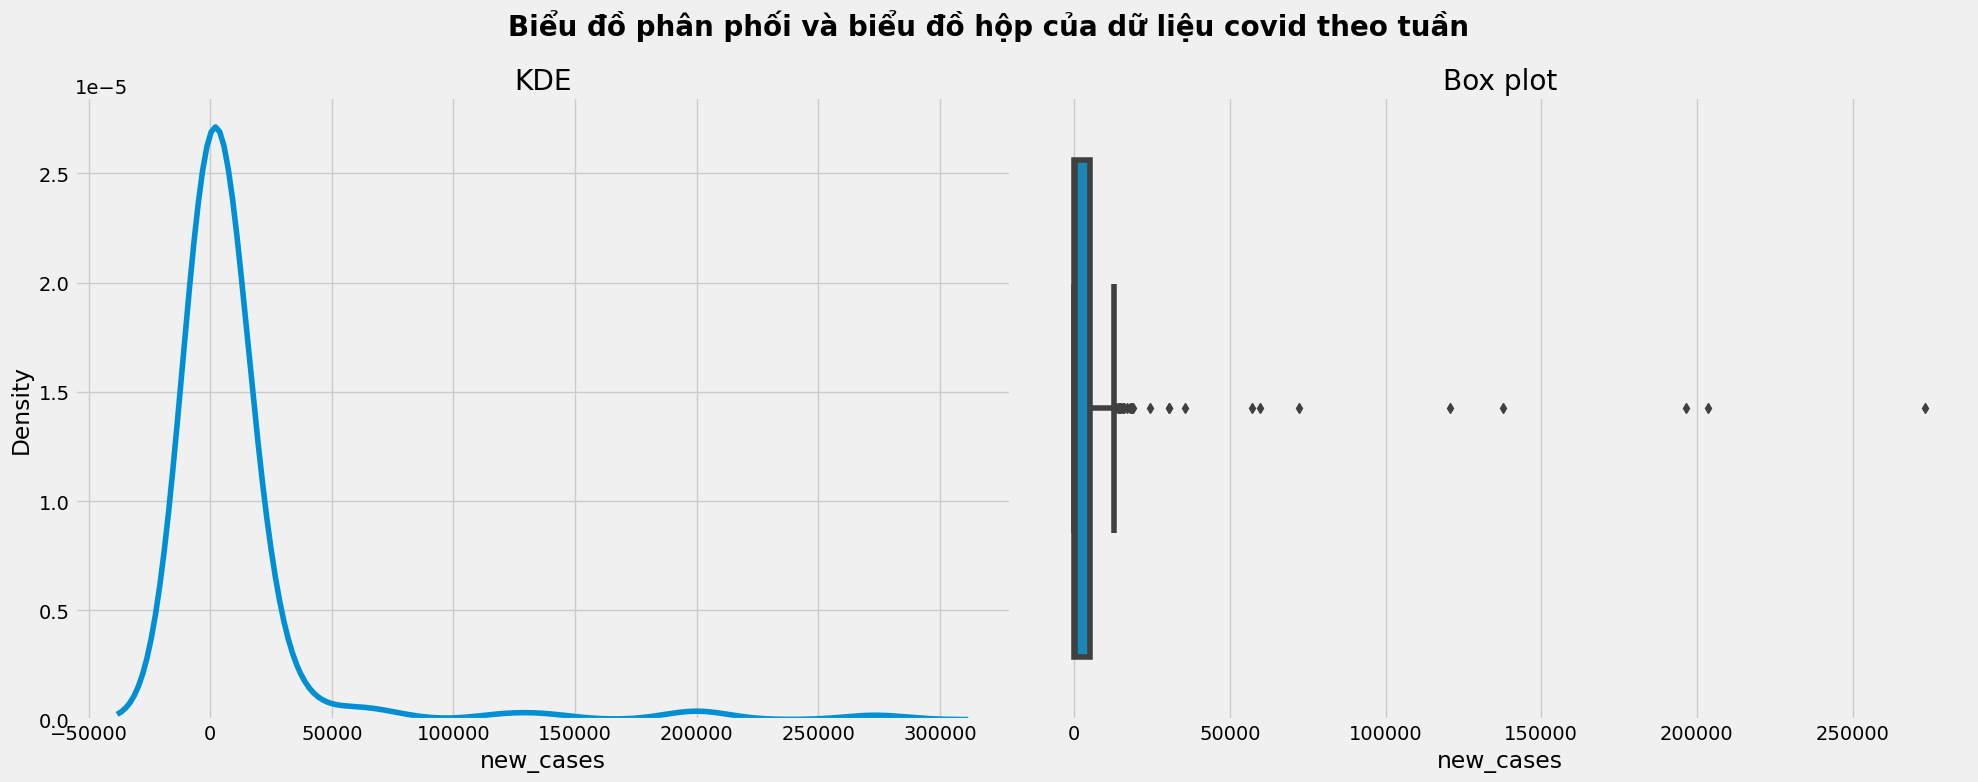

In [19]:
plot_kde_box(df, title='Biểu đồ phân phối và biểu đồ hộp của dữ liệu covid theo tuần')

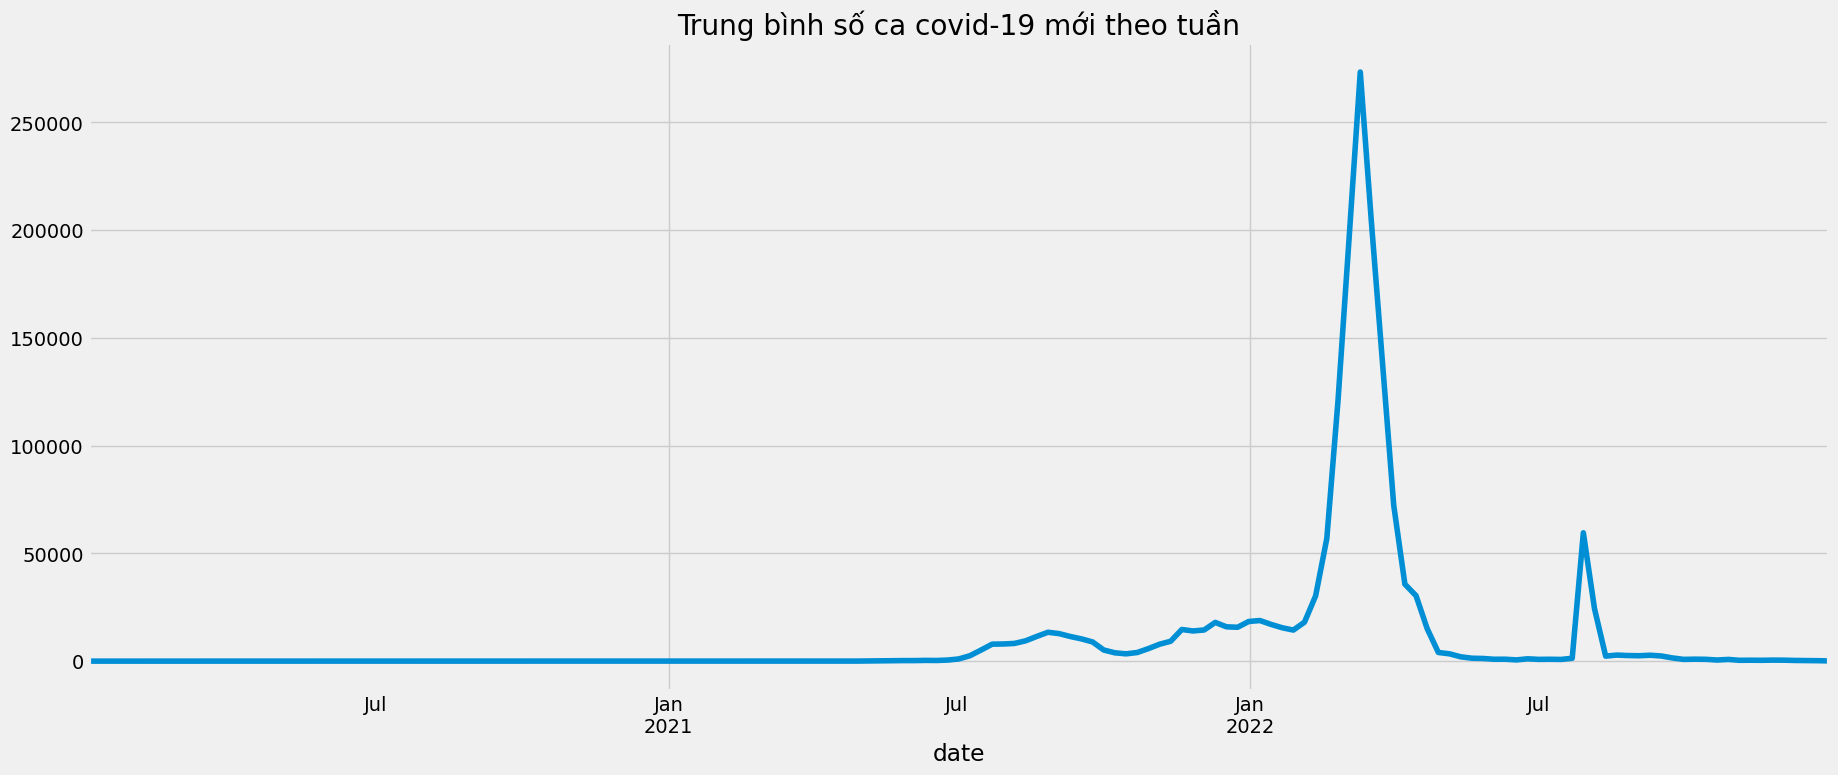

In [20]:
train_7D.plot(title="Trung bình số ca covid-19 mới theo tuần")
plt.show()

In [21]:
check_stationarity(train_7D)

'Stationary	 p-value:1.4430577521377731e-05 	 lags:1


('Stationary', 1.4430577521377731e-05)

In [22]:
train_7D_dif1 = train_7D.diff().dropna()
check_stationarity(train_7D_dif1)

'Stationary	 p-value:4.1147464091059386e-12 	 lags:2


('Stationary', 4.1147464091059386e-12)

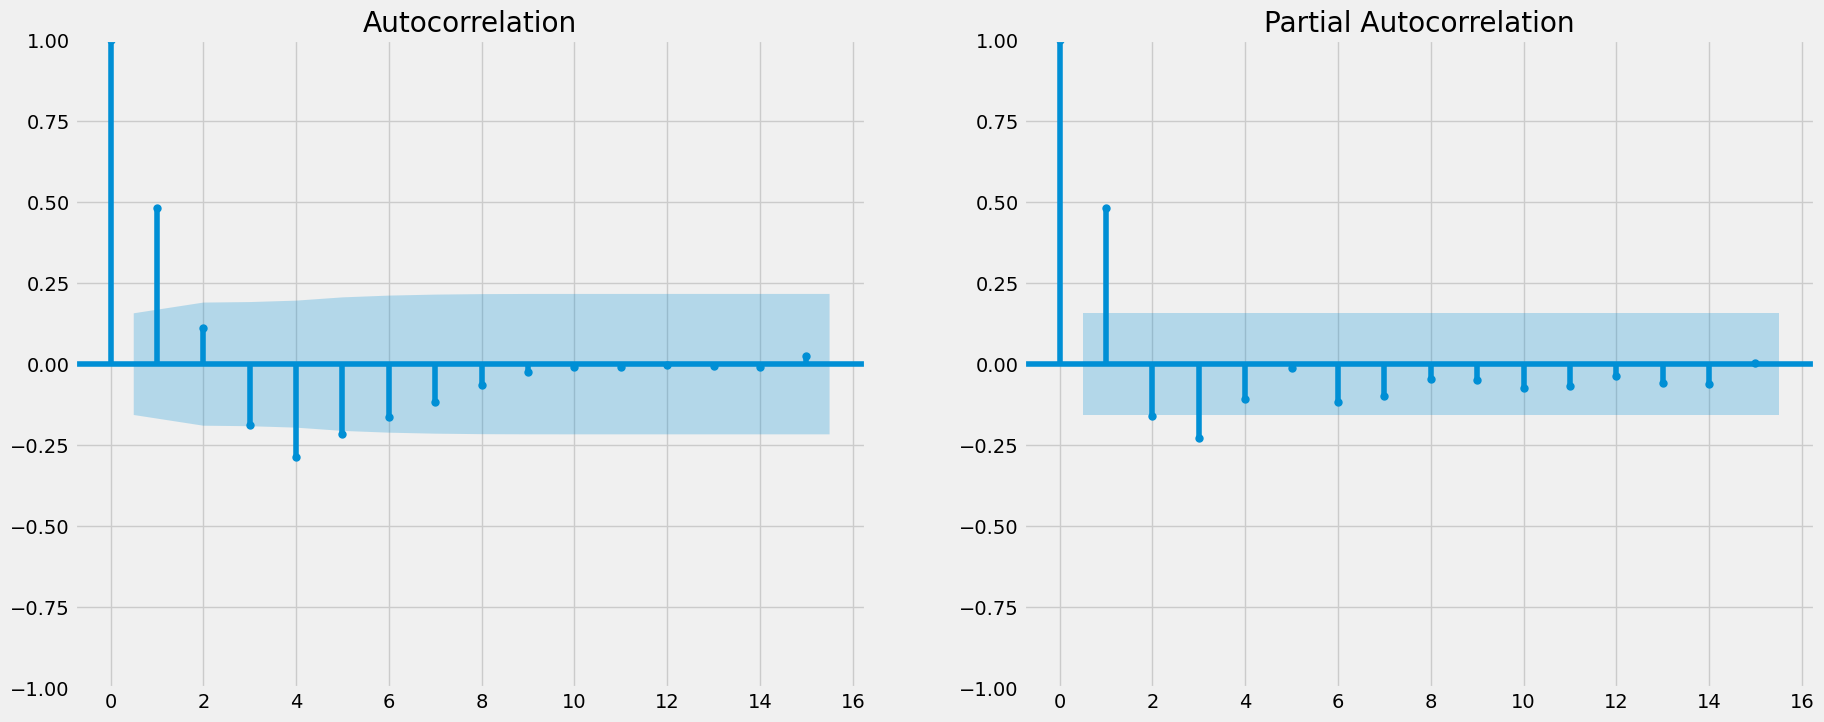

In [23]:
fig, ax = plt.subplots(1,2)
plot_acf(train_7D_dif1, ax=ax[0], lags=15)
plot_pacf(train_7D_dif1, ax=ax[1], lags=15); plt.show()

### Sử dụng mô hình thống kê

In [24]:
orders = [
    [(0, 0, 1), (0, 1, 3)],
    [(1, 0, 1), (1, 1, 3)],
    [(4, 0, 1), (4, 1, 3)]
]

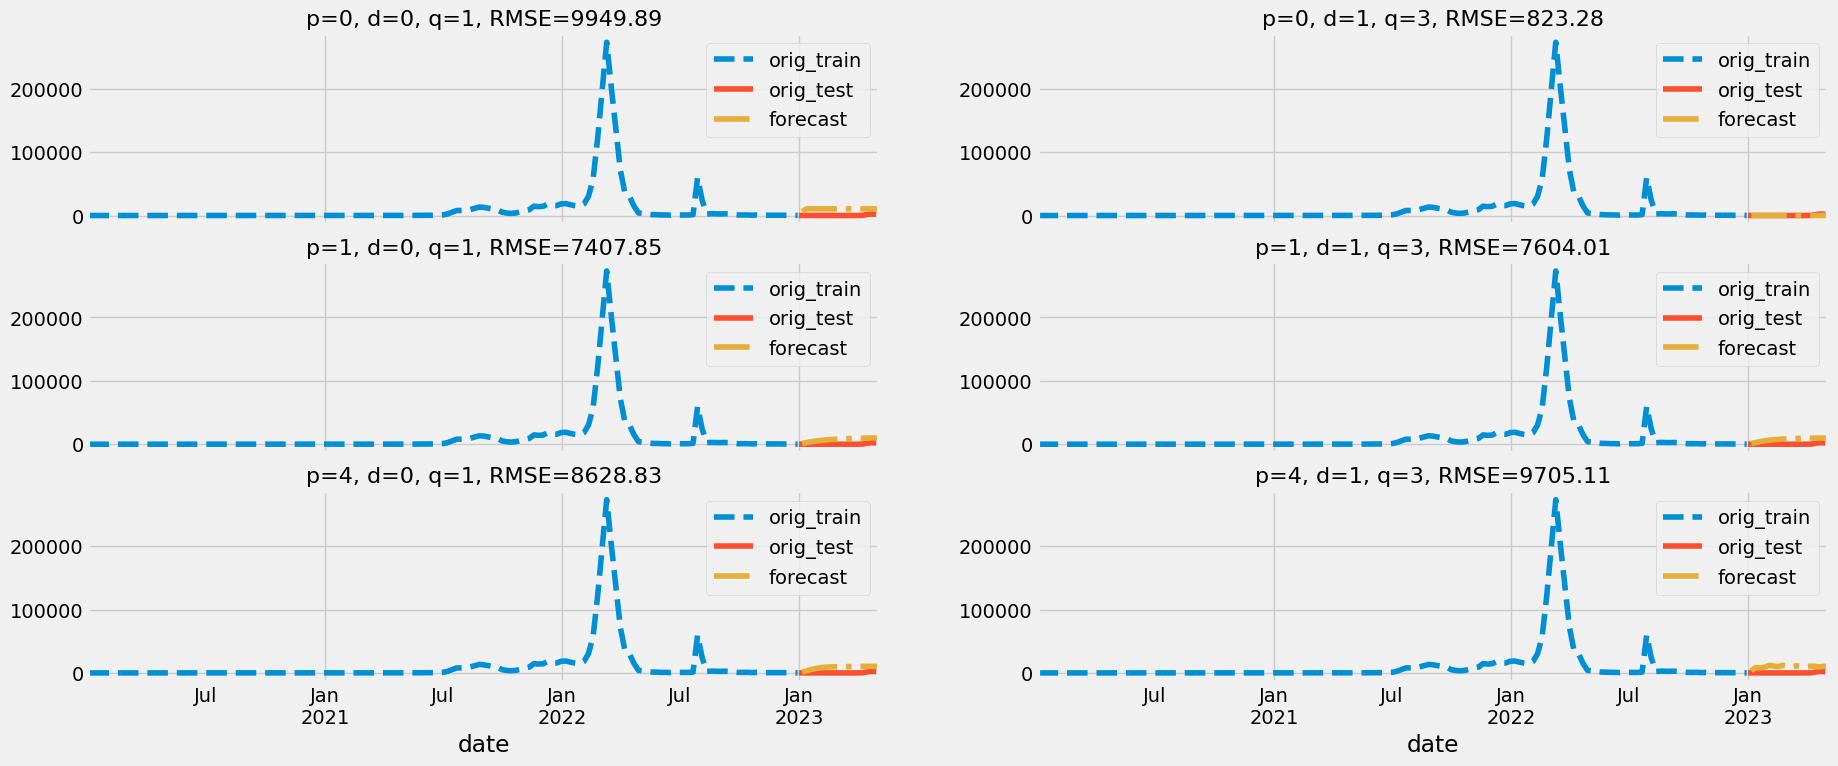

In [40]:
test = test[test.index <= '2023-05-01']
test_7D = test.resample('7D').mean()
fig, axs = plt.subplots(3, 2, sharex=True)
for i in range(3):
    for j in range(2):
        model = ARIMA(train_7D, order=orders[i][j])
        results = model.fit()
        forecast = plot_forecast(results, '2020', train_7D, test_7D, orders[i][j], axs[i][j])

> Từ biểu đồ kết quả trên, chúng ta sẽ lựa chọn model ARIMA với $p = 0, d = 1, q = 3$

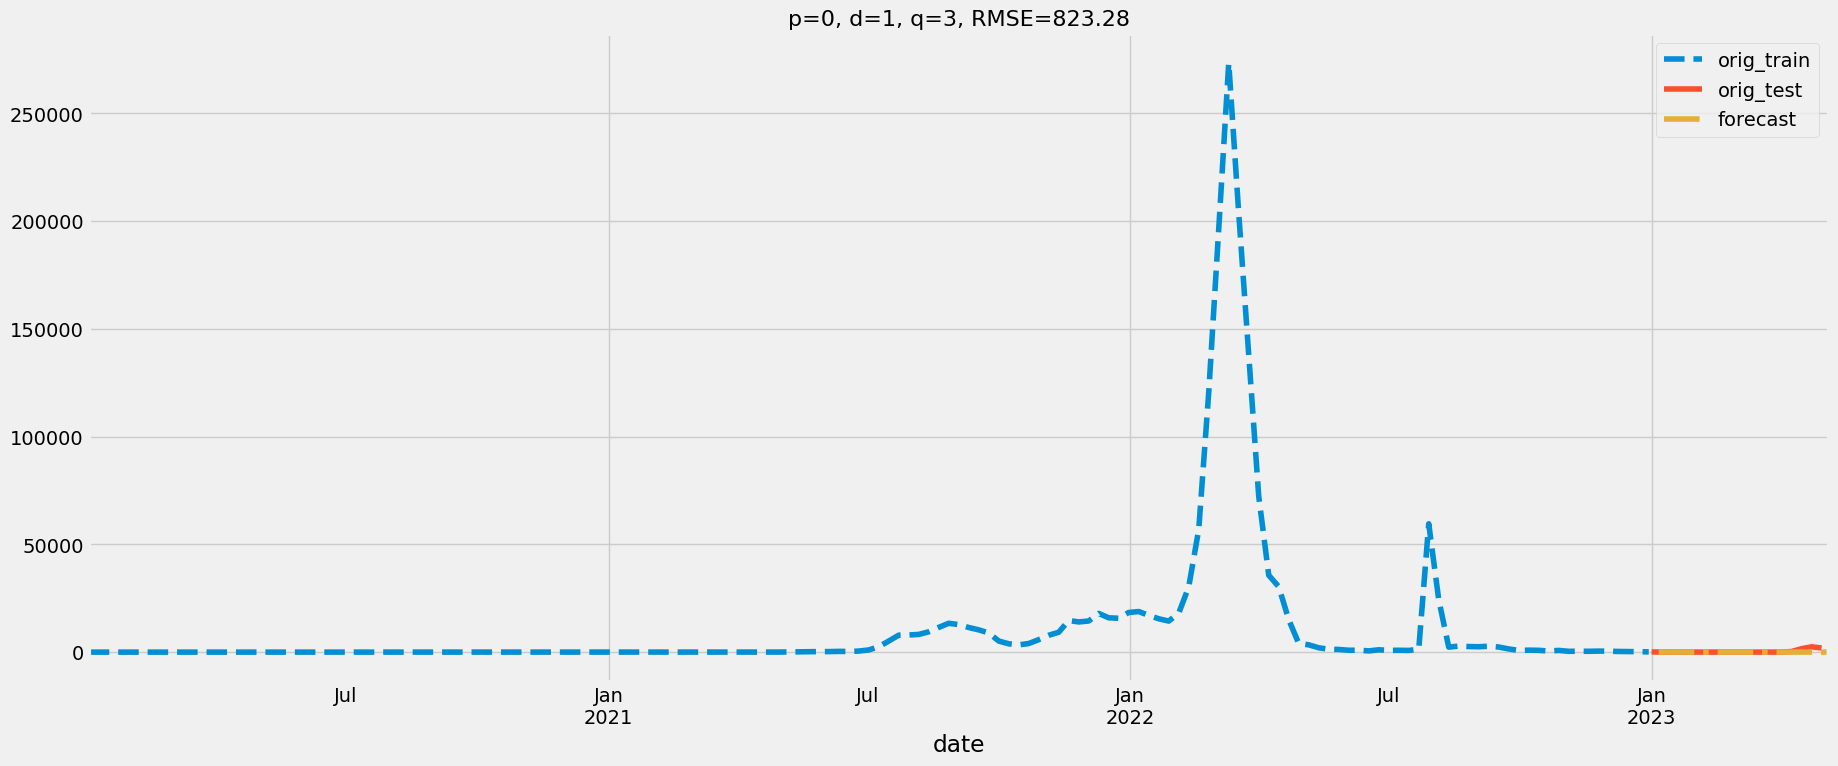

In [43]:
fig, axs = plt.subplots(1, 1)
best_model = ARIMA(train_7D, order=(0, 1, 3))
results = best_model.fit()
forecast = plot_forecast(results, '2020', train_7D, test_7D, order=(0, 1, 3), ax = axs)
plt.show()

> Sau khi chọn ra được tham số hợp lý, chúng ta sẽ dự đoán ca covid các tuần trong năm 2023, lúc này tệp data sẽ là toàn bộ dữ liệu của chúng ta

In [49]:
train_all = vn_data['new_cases']

train_all = train_all[train_all.index < '2023-05-01']

In [51]:
train_all_7D = train_all.resample('7D').mean()

In [79]:
model = ARIMA(train_all_7D, order=(0, 1, 3))
results = model.fit()
forecast = results.forecast(4)

In [80]:
pd.DataFrame(forecast)

,predicted_mean
2023-05-05,2749.091342
2023-05-12,2686.401231
2023-05-19,2661.932062
2023-05-26,2661.932062


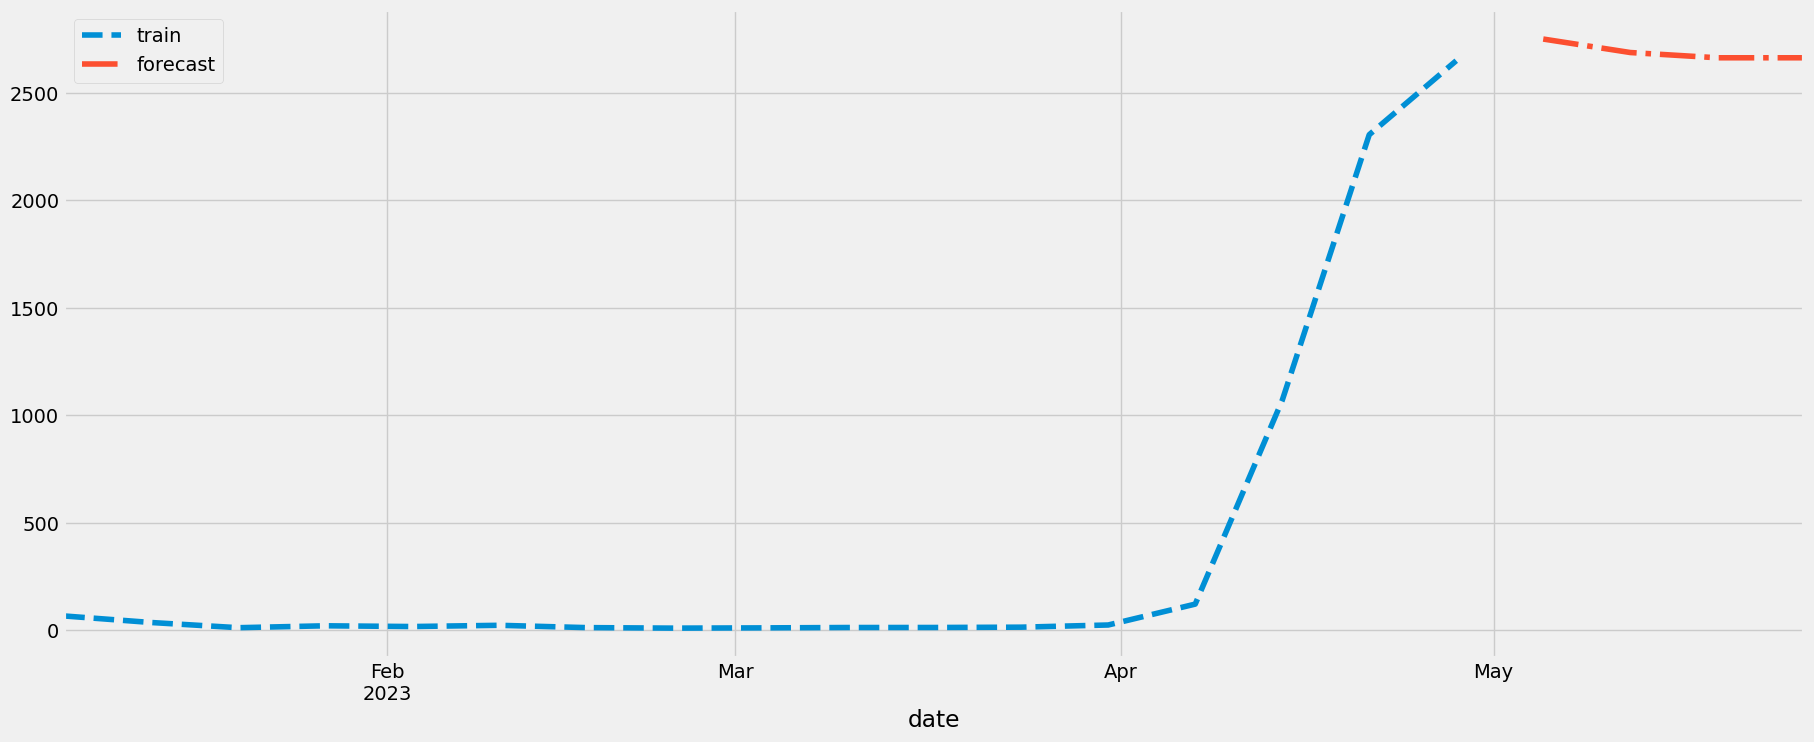

In [81]:
ax = train_all_7D[train_all_7D.index >= '2023'].plot(style='--')
forecast.plot(ax=ax, style='-.')
ax.legend(['train', 'forecast'])
plt.show()

![thucte](https://suckhoedoisong.qltns.mediacdn.vn/324455921873985536/2023/5/21/camoi215-1684664930876375210339.jpeg)

> Như đã nhận định, yếu tố chính gây lên covid-19 là con người vì hiện nay Covid-19 cũng không phải còn trên xu hướng như những năm 2020 hay 2021 nên việc người dân đi kê khai mắc covid-19 cũng không còn nhiều, vậy nên chúng ta chỉ có thể dựa vào mô hình mà đánh giá ước lượng khoảng bao nhiêu ca mắc mới trung bình theo tuần, tuy nhiên xu hướng mô hình của chúng ta dự đoán khá đúng đó là đầu tháng 5 sẽ tăng lên và sau đó sẽ giảm xuống

## Xây dựng mô hình học máy

In [82]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'],
                        index=idx)
    return pd.concat([df_y, df_xs], axis=1).dropna()

Mô hình học máy thường có độ chính xác cao hơn so với mô hình thống kê, vậy liệu chúng ta có thể xây dựng dự đoán theo ngày không ?

In [111]:
df = vn_data['new_cases']

In [112]:
df_os = one_step_forecast(df, window=5)

In [113]:
X, y = df_os.iloc[:, 1:], df_os.iloc[:, 0]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

In [134]:
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (1089, 5)
Test size: (121, 5)


In [135]:
scaler_feature = StandardScaler()
scaler_label = StandardScaler()

y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

scaler_feature.fit(X_train)
X_train_scaled = scaler_feature.transform(X_train)
X_test_scaled = scaler_feature.transform(X_test)

scaler_label.fit(y_train)
y_train_scaled = scaler_label.transform(y_train)

### Linear Regression

In [149]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train_scaled, y_train_scaled)

yhat = reg.predict(X_test_scaled)

yhat_actual = scaler_label.inverse_transform(
    np.reshape(yhat, (-1, 1))
)
rmse_test = np.sqrt(mean_squared_error(yhat_actual, y_test))
rmse_test

653.0235695583502

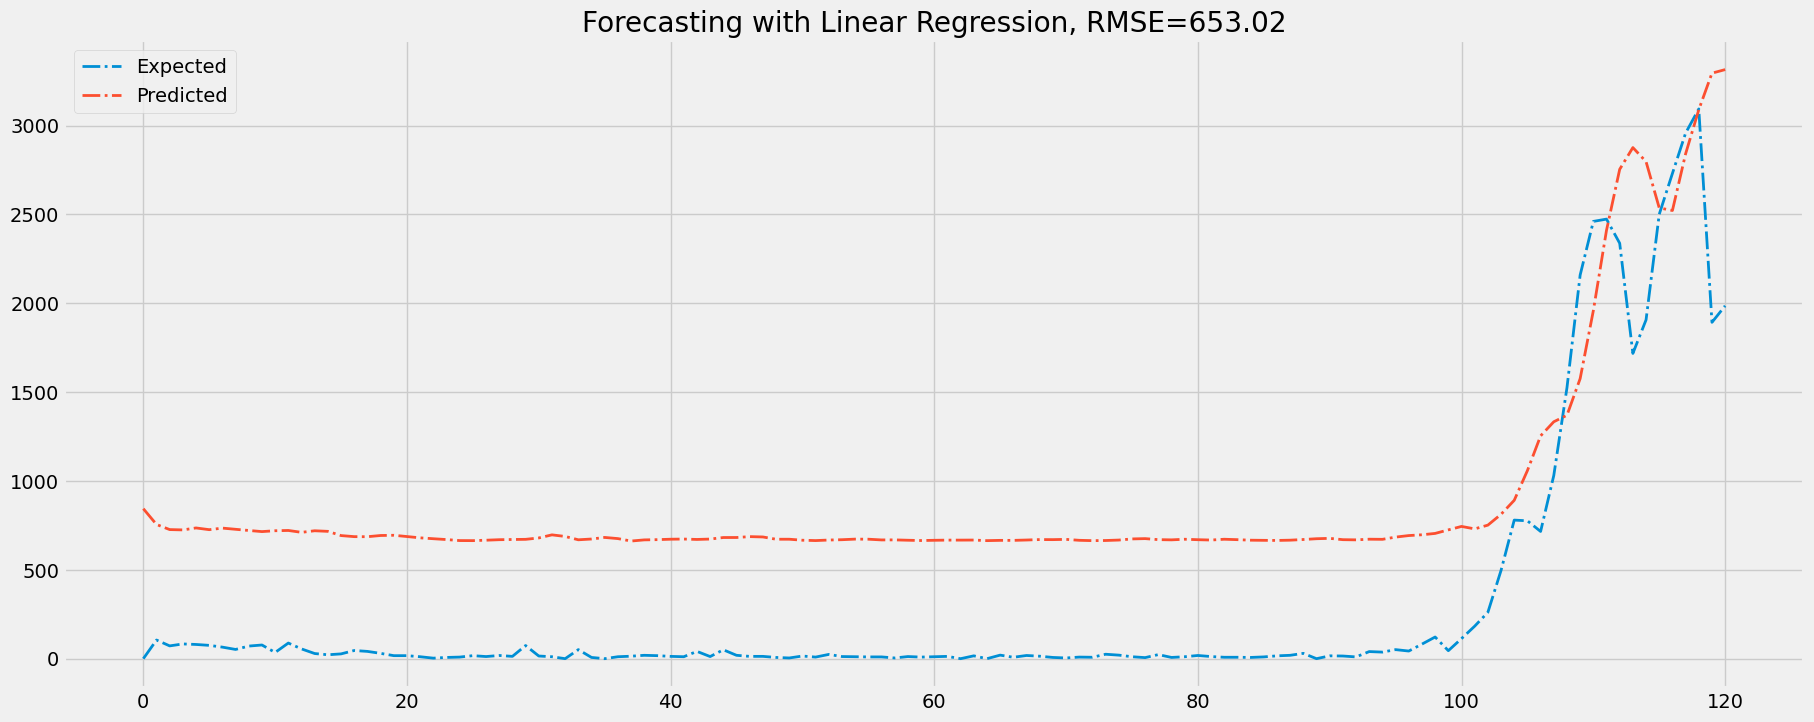

In [150]:
plt.plot(y_test, label='Expected', linewidth=2, linestyle='-.')
plt.plot(yhat_actual, label='Predicted', linewidth=2, linestyle='-.')
plt.legend()
plt.title(f'Forecasting with Linear Regression, RMSE={round(rmse_test, 2)}')
plt.show()

### AdaBoost Regressor

In [237]:
reg = AdaBoostRegressor(n_estimators=20, random_state=221, loss='square')
reg.fit(X_train_scaled, y_train_scaled)

yhat = reg.predict(X_test_scaled)

yhat_actual = scaler_label.inverse_transform(
    np.reshape(yhat, (-1, 1))
)
rmse_test = np.sqrt(mean_squared_error(yhat_actual, y_test))
rmse_test

973.8511699401498

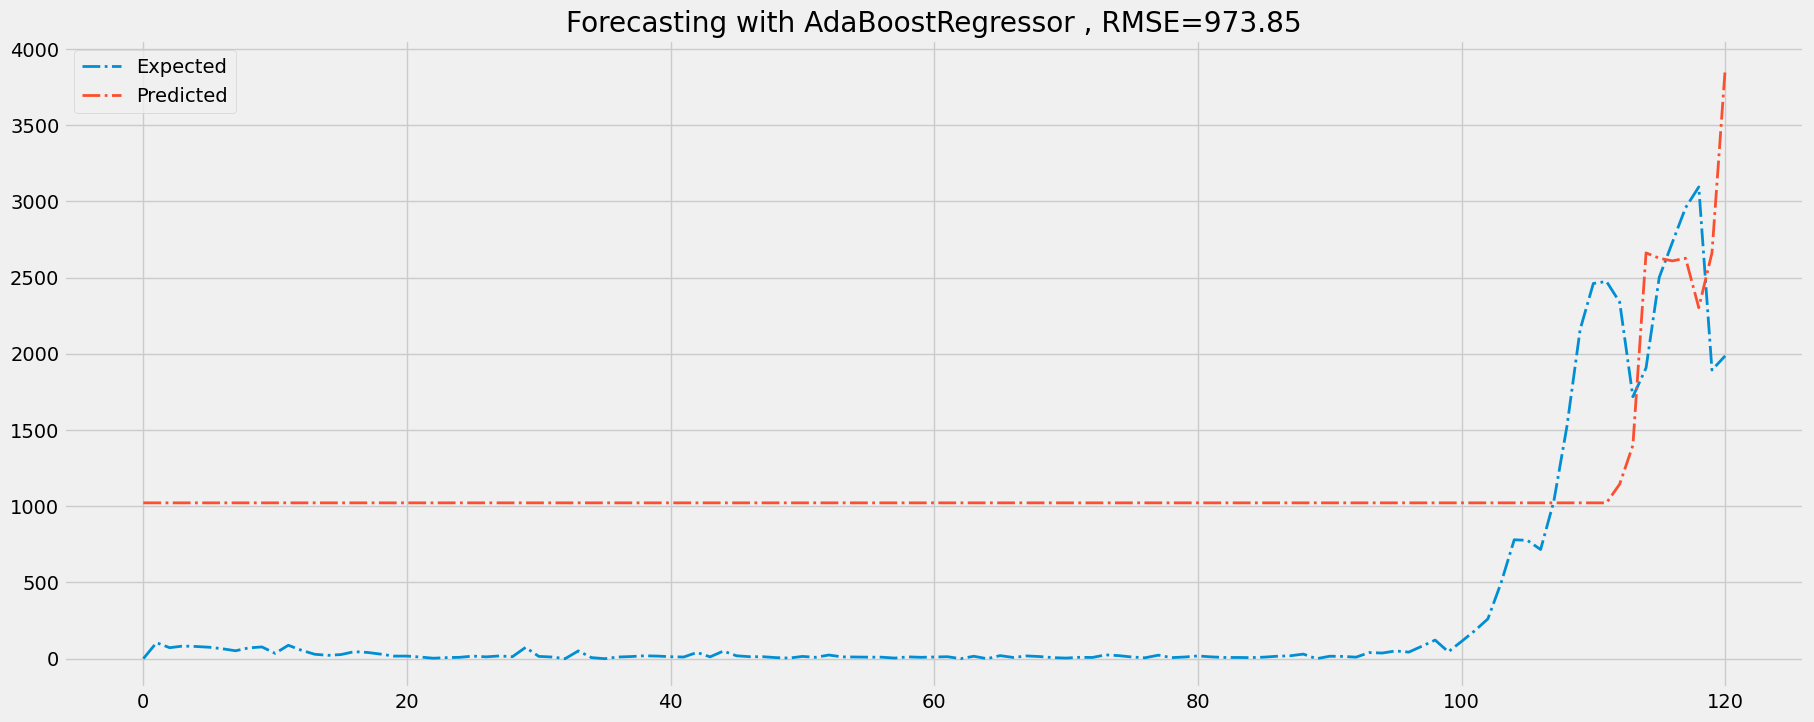

In [238]:
plt.plot(y_test, label='Expected', linewidth=2, linestyle='-.')
plt.plot(yhat_actual, label='Predicted', linewidth=2, linestyle='-.')
plt.legend()
plt.title(f'Forecasting with AdaBoostRegressor , RMSE={round(rmse_test, 2)}')
plt.show()

### GridSearch CV + AdaBoostRegressor

In [243]:
def draw_true_predict(y_true, y_pred):
    size = len(y_true)
    plt.plot(list(range(size)), y_true, label='real', color='blue')
    plt.plot(list(range(size)), y_pred, label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Real vs Predicted values')
    plt.show()

def calculate_metrics(y_true, y_pred):
    # Calculate metrics
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    print(f"RMSE: {RMSE}, MAPE: {MAPE}, R2: {R2}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..loss=linear, n_estimators=10;, score=-5297.297 total time=   0.0s
[CV 2/5] END ..loss=linear, n_estimators=10;, score=-2247.005 total time=   0.0s
[CV 3/5] END ....loss=linear, n_estimators=10;, score=-16.336 total time=   0.0s
[CV 4/5] END .....loss=linear, n_estimators=10;, score=-0.208 total time=   0.0s
[CV 5/5] END .....loss=linear, n_estimators=10;, score=-0.013 total time=   0.0s
[CV 1/5] END ..loss=linear, n_estimators=20;, score=-6043.159 total time=   0.0s
[CV 2/5] END ..loss=linear, n_estimators=20;, score=-2821.169 total time=   0.0s
[CV 3/5] END ....loss=linear, n_estimators=20;, score=-16.355 total time=   0.0s
[CV 4/5] END .....loss=linear, n_estimators=20;, score=-0.204 total time=   0.0s
[CV 5/5] END .....loss=linear, n_estimators=20;, score=-0.002 total time=   0.0s
[CV 1/5] END .loss=linear, n_estimators=30;, score=-11116.900 total time=   0.0s
[CV 2/5] END ..loss=linear, n_estimators=30;, sc

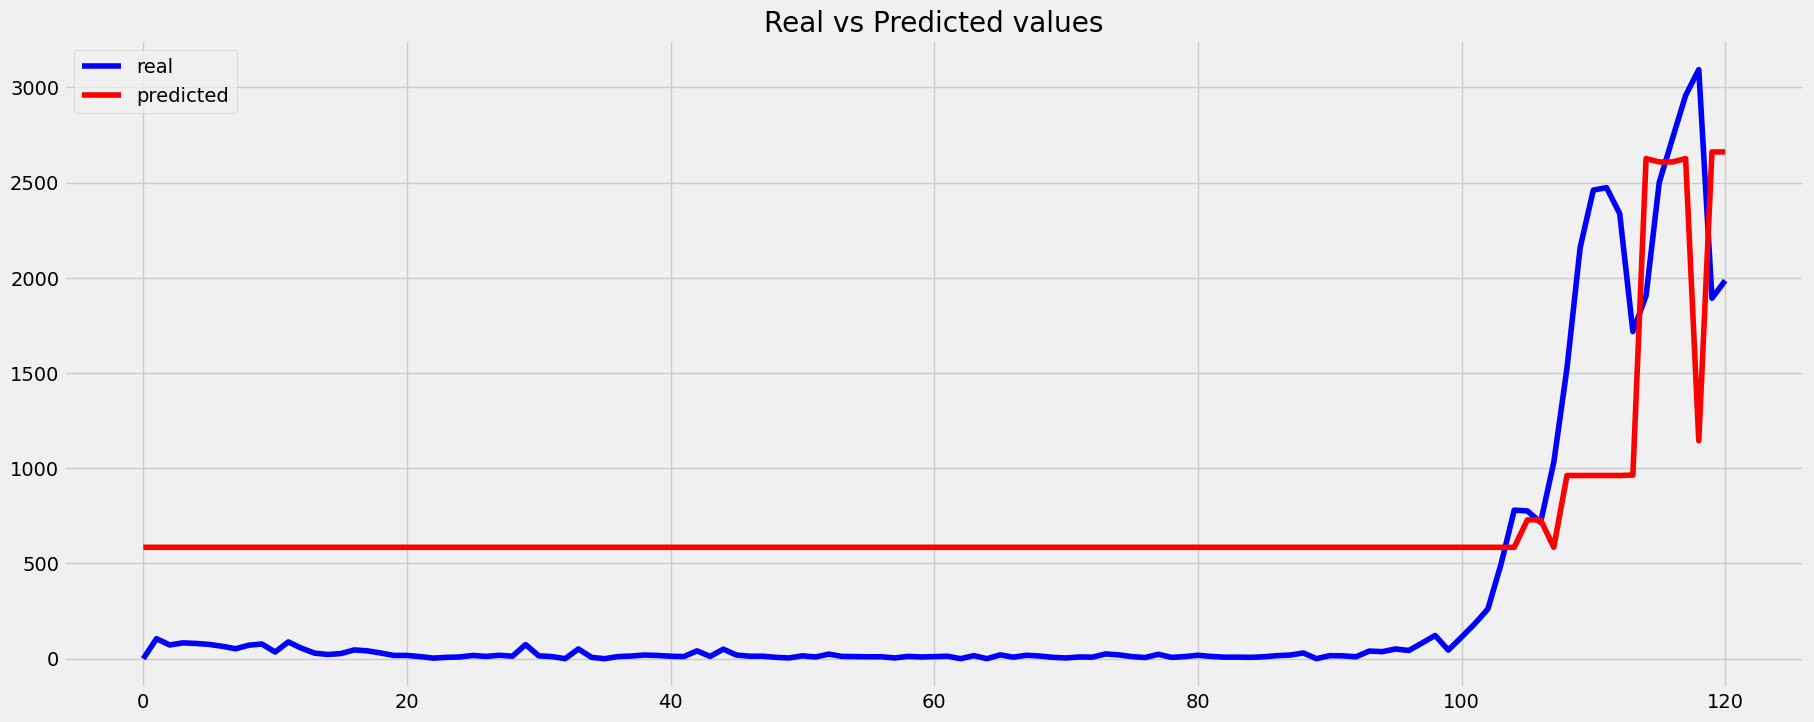

In [245]:
# defining parameter range
param_grid = {
    'n_estimators': [x + 10 for x in range(0, 41, 10)],
    'loss': ['linear', 'square', 'exponential']
}

grid = GridSearchCV(AdaBoostRegressor(random_state=221), param_grid, refit=True, verbose=3)
grid.fit(X_train_scaled, y_train_scaled)

pred = grid.predict(X_test_scaled)

# Calculate metrics
calculate_metrics(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))

draw_true_predict(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))

### GridSearchCV + Huber Regressor

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
[CV 1/5] END ..........epsilon=1.0, max_iter=50;, score=0.407 total time=   0.0s
[CV 2/5] END ..........epsilon=1.0, max_iter=50;, score=0.251 total time=   0.0s
[CV 3/5] END ..........epsilon=1.0, max_iter=50;, score=0.945 total time=   0.0s
[CV 4/5] END ..........epsilon=1.0, max_iter=50;, score=0.789 total time=   0.0s
[CV 5/5] END .........epsilon=1.0, max_iter=50;, score=-0.372 total time=   0.0s
[CV 1/5] END .........epsilon=1.0, max_iter=150;, score=0.396 total time=   0.0s
[CV 2/5] END .........epsilon=1.0, max_iter=150;, score=0.251 total time=   0.0s
[CV 3/5] END .........epsilon=1.0, max_iter=150;, score=0.945 total time=   0.1s
[CV 4/5] END .........epsilon=1.0, max_iter=150;, score=0.789 total time=   0.0s
[CV 5/5] END ........epsilon=1.0, max_iter=150;, score=-0.374 total time=   0.0s
[CV 1/5] END .........epsilon=1.0, max_iter=250;, score=0.396 total time=   0.0s
[CV 2/5] END .........epsilon=1.0, max_iter=2

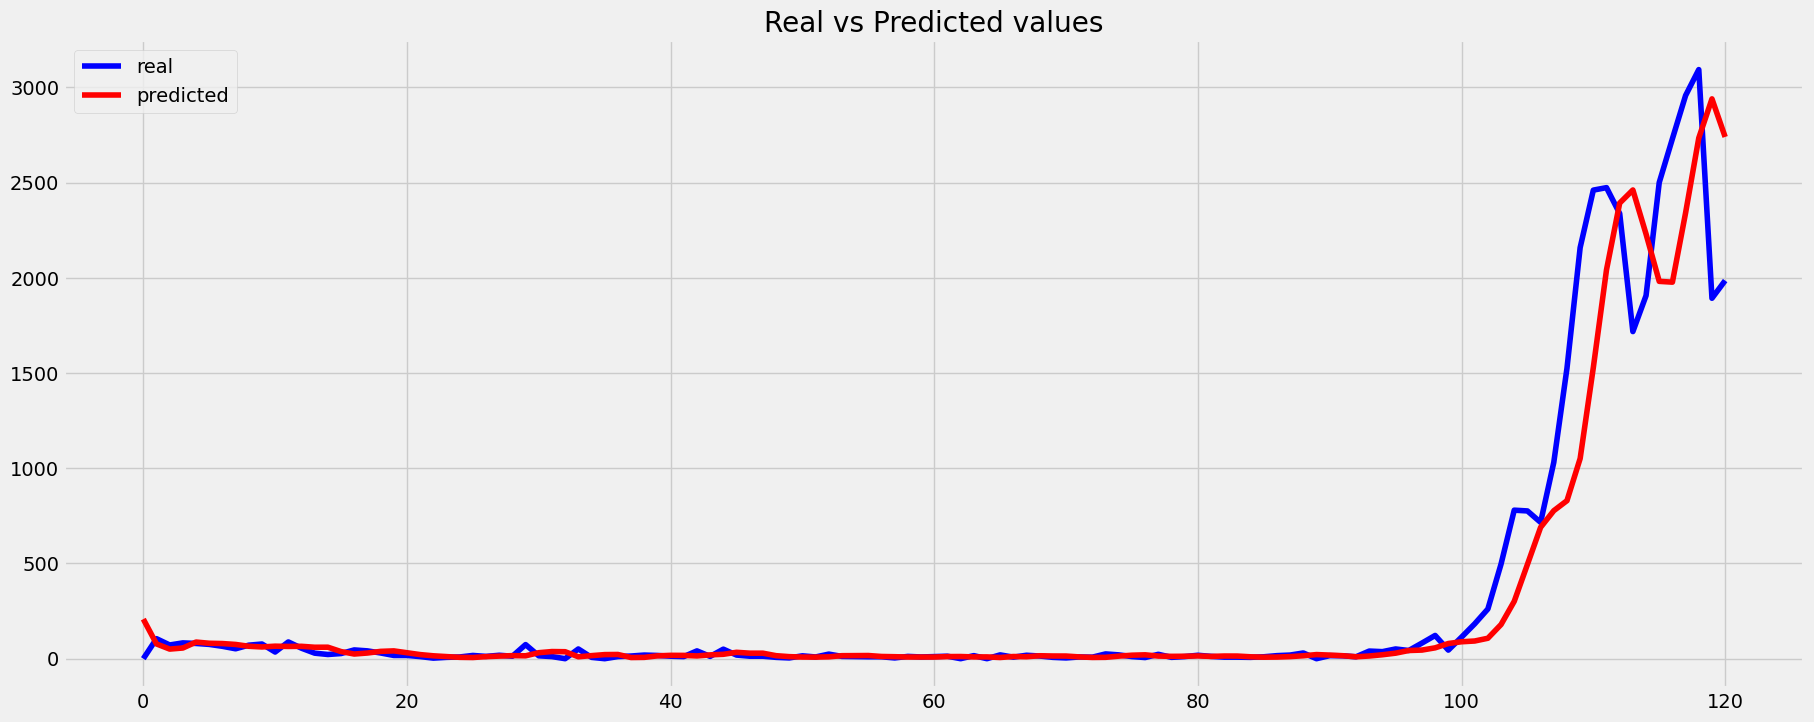

In [279]:
epsilon = np.linspace(1, 2, 21)
max_iter = [x + 50 for x in range(0, 1000, 100)]
max_iter.append(1000)
# max_iter
# epsilon
param_grid = {
    'epsilon': list(epsilon),
    'max_iter': max_iter
}

grid = GridSearchCV(HuberRegressor(fit_intercept=False), param_grid, refit=True, verbose=3)
grid.fit(X_train_scaled, y_train_scaled)

pred = grid.predict(X_test_scaled)

# Calculate metrics
calculate_metrics(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))

draw_true_predict(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))

### GridSearch CV + Lasso

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
[CV 1/5] END ........alpha=0.0, max_iter=50;, score=-6129.722 total time=   0.0s
[CV 2/5] END ........alpha=0.0, max_iter=50;, score=-2649.777 total time=   0.0s
[CV 3/5] END ............alpha=0.0, max_iter=50;, score=0.936 total time=   0.0s
[CV 4/5] END ............alpha=0.0, max_iter=50;, score=0.705 total time=   0.0s
[CV 5/5] END ...........alpha=0.0, max_iter=50;, score=-0.126 total time=   0.0s
[CV 1/5] END .......alpha=0.0, max_iter=150;, score=-6140.442 total time=   0.0s
[CV 2/5] END .......alpha=0.0, max_iter=150;, score=-2654.409 total time=   0.0s
[CV 3/5] END ...........alpha=0.0, max_iter=150;, score=0.936 total time=   0.0s
[CV 4/5] END ...........alpha=0.0, max_iter=150;, score=0.705 total time=   0.0s
[CV 5/5] END ..........alpha=0.0, max_iter=150;, score=-0.129 total time=   0.0s
[CV 1/5] END .......alpha=0.0, max_iter=250;, score=-6140.442 total time=   0.0s
[CV 2/5] END .......alpha=0.0, max_iter=250;,

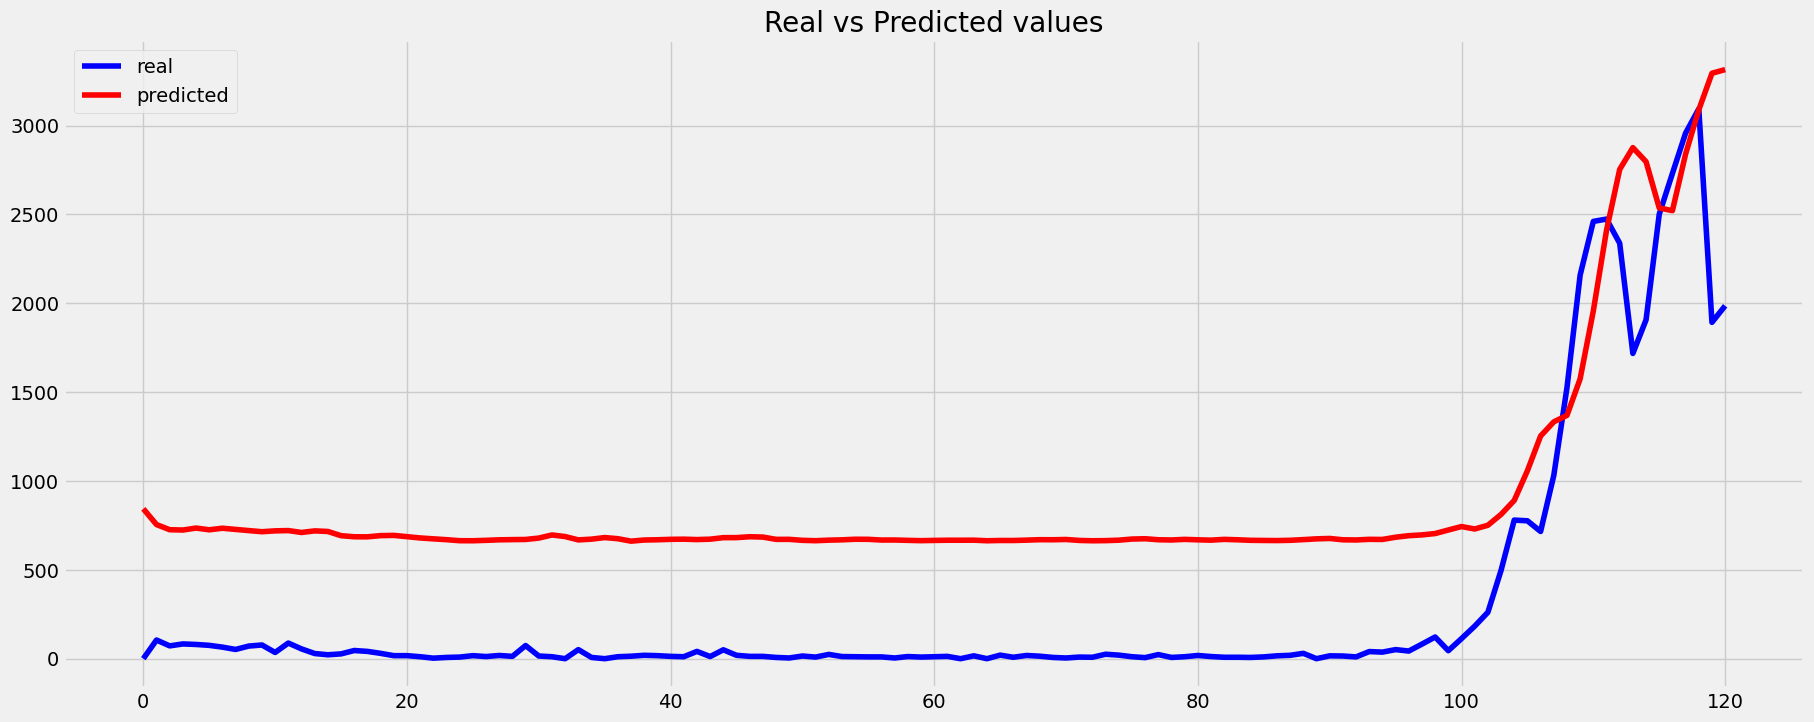

In [282]:
alpha = np.linspace(0, 1, 20)
max_iter = [x + 50 for x in range(0, 1000, 100)]
max_iter.append(1000)
# max_iter
# epsilon
param_grid = {
    'alpha': list(alpha),
    'max_iter': max_iter
}

grid = GridSearchCV(Lasso(fit_intercept=False, random_state=221), param_grid, refit=True, verbose=3)
grid.fit(X_train_scaled, y_train_scaled)

pred = grid.predict(X_test_scaled)

# Calculate metrics
calculate_metrics(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))

draw_true_predict(y_test, scaler_label.inverse_transform(np.reshape(pred, (-1, 1))))